<a href="https://colab.research.google.com/github/tonyfu97/468ArduinoCPR/blob/main/Emotion_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion AI: Facial Keypoints Detection & Emotion Classification

Reference: Modern Artificial Intelligence Masterclass by Dr. Ryan Ahmed

Data sources:
* Facial Keypoints: https://www.kaggle.com/c/facial-keypoints-detection/overview
* Facial Expression: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

## Preliminaries

In [1]:
try:
    import google.colab
    # Mount the drive
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/My Drive/Portfolio-AI/Emotion-AI/
except ModuleNotFoundError:
    print("Not running on Colab; skipping drive mount.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Portfolio-AI/Emotion-AI


In [2]:
import pandas as pd
import numpy as np
import os
import copy
import random
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

## Part I: Facial Keypoints Detection




### Load data

In [3]:
keyfacial_df = pd.read_csv('data.csv')
keyfacial_df.info()
assert keyfacial_df.isnull().sum().any() == 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [4]:
keyfacial_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


In [5]:
# Note that the last column contains the images in the form of a string. We need to reshape it to (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x : np.fromstring(x, dtype=int, sep=' ').reshape(96, 96))
assert keyfacial_df['Image'][0].shape == (96, 96)

In [6]:
COLUMNS = keyfacial_df.columns[:-1]
print(COLUMNS)

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')


### Visualize Facial Images

In [7]:
def plot_keypoints(kp_df : pd.DataFrame, row : int) -> None:
    for j in range(1,31,2):
        plt.plot(kp_df.loc[row][j-1], kp_df.loc[row][j], 'rx')

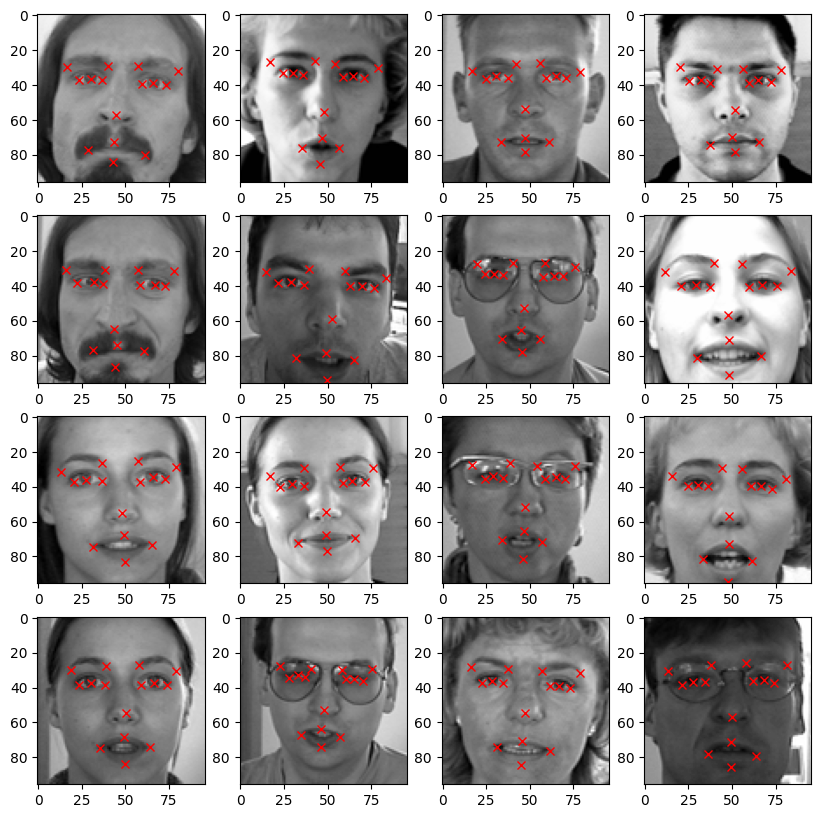

In [8]:
# Viewing some random faces
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
    plot_keypoints(keyfacial_df, i)

### Data Augmentation: Improve Generalization

In [9]:
def plot_original_vs_augmented(original_df, augmented_arr, face_id):
    plt.subplot(1,2,1)
    plt.imshow(original_df['Image'][face_id], cmap = 'gray')
    plot_keypoints(original_df, face_id)
    plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(augmented_arr['Image'][face_id], cmap = 'gray')
    plot_keypoints(augmented_arr, face_id)
    plt.title("Augmented")
    plt.show()

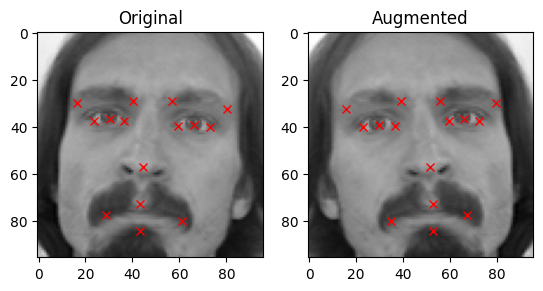

(4280, 31)


In [10]:
# Horizontal Flip
keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))
for i in range(len(COLUMNS)):
  if i%2 == 0:
    keyfacial_df_copy[COLUMNS[i]] = keyfacial_df_copy[COLUMNS[i]].apply(lambda x: 96. - float(x) )

plot_original_vs_augmented(keyfacial_df, keyfacial_df_copy, 0)
augmented_arr = np.concatenate((keyfacial_df, keyfacial_df_copy))
print(augmented_arr.shape)

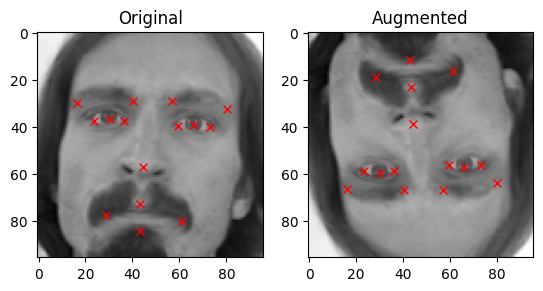

(6420, 31)


In [11]:
# Vertical Flip
keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))
for i in range(len(COLUMNS)):
  if i%2 == 1:
    keyfacial_df_copy[COLUMNS[i]] = keyfacial_df_copy[COLUMNS[i]].apply(lambda x: 96. - float(x) )

plot_original_vs_augmented(keyfacial_df, keyfacial_df_copy, 0)
augmented_arr = np.concatenate((augmented_arr, keyfacial_df_copy))
print(augmented_arr.shape)

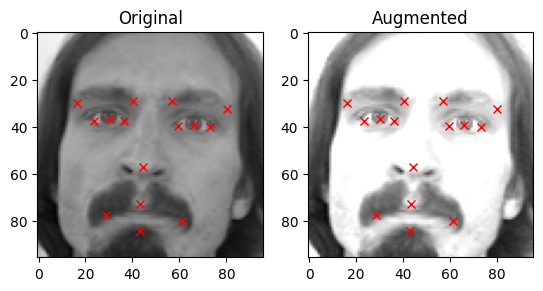

(12840, 31)


In [51]:
# Randomly increase brightness
keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))

plot_original_vs_augmented(keyfacial_df, keyfacial_df_copy, 0)
augmented_arr = np.concatenate((augmented_arr, keyfacial_df_copy))
print(augmented_arr.shape)

### Data Normalization & Scaling

In [13]:
img = augmented_arr[:, 30] / 255.0
X = np.array([np.expand_dims(image, axis=-1) for image in img], dtype=np.float32)
print(X.shape)

(8560, 96, 96, 1)


In [14]:
keypoints = augmented_arr[:,:30]
y = np.asarray(keypoints).astype(np.float32)
print(y.shape)

(8560, 30)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [16]:
print(X_train.shape, X_test.shape)

(6848, 96, 96, 1) (1712, 96, 96, 1)


### Build ResNet

In [18]:
def res_block(X, filter, stage):
    # Helper submodules
    def convolutional_block(X, stage, filters):
        X_copy = X

        f1, f2, f3 = filters

        # Main Path
        X = Conv2D(f1, (1, 1), strides=(1, 1), name='res_' + str(stage) + '_conv_a', kernel_initializer=glorot_uniform(seed=0))(X)
        X = MaxPool2D((2, 2))(X)
        X = BatchNormalization(axis=3, name='bn_' + str(stage) + '_conv_a')(X)
        X = Activation('relu')(X)

        X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name='res_' + str(stage) + '_conv_b', kernel_initializer=glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis=3, name='bn_' + str(stage) + '_conv_b')(X)
        X = Activation('relu')(X)

        X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_' + str(stage) + '_conv_c', kernel_initializer=glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis=3, name='bn_' + str(stage) + '_conv_c')(X)

        # Short path
        X_copy = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_' + str(stage) + '_conv_copy', kernel_initializer=glorot_uniform(seed=0))(X_copy)
        X_copy = MaxPool2D((2, 2))(X_copy)
        X_copy = BatchNormalization(axis=3, name='bn_' + str(stage) + '_conv_copy')(X_copy)

        # ADD
        X = Add()([X, X_copy])
        X = Activation('relu')(X)

        return X


    def identity_block1(X, stage, filters):
        X_copy = X

        f1, f2, f3 = filters

        # Main Path
        X = Conv2D(f1, (1, 1), strides=(1, 1), name='res_' + str(stage) + '_identity_1_a', kernel_initializer=glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis=3, name='bn_' + str(stage) + '_identity_1_a')(X)
        X = Activation('relu')(X)

        X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name='res_' + str(stage) + '_identity_1_b', kernel_initializer=glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis=3, name='bn_' + str(stage) + '_identity_1_b')(X)
        X = Activation('relu')(X)

        X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_' + str(stage) + '_identity_1_c', kernel_initializer=glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis=3, name='bn_' + str(stage) + '_identity_1_c')(X)

        # ADD
        X = Add()([X, X_copy])
        X = Activation('relu')(X)

        return X

    def identity_block2(X, stage, filters):
        X_copy = X

        f1, f2, f3 = filters

        # Main Path
        X = Conv2D(f1, (1, 1), strides=(1, 1), name='res_' + str(stage) + '_identity_2_a', kernel_initializer=glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis=3, name='bn_' + str(stage) + '_identity_2_a')(X)
        X = Activation('relu')(X)

        X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name='res_' + str(stage) + '_identity_2_b', kernel_initializer=glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis=3, name='bn_' + str(stage) + '_identity_2_b')(X)
        X = Activation('relu')(X)

        X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_' + str(stage) + '_identity_2_c', kernel_initializer=glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis=3, name='bn_' + str(stage) + '_identity_2_c')(X)

        # ADD
        X = Add()([X, X_copy])
        X = Activation('relu')(X)

        return X

    X = convolutional_block(X, stage, filter)
    X = identity_block1(X, stage, filter)
    X = identity_block2(X, stage, filter)

    return X

In [19]:
def build_model(input_shape):
    X_input = Input(input_shape)

    # Zero-padding
    X = ZeroPadding2D((3, 3))(X_input)

    # 1 - stage
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 2 - stage
    X = res_block(X, [64, 64, 256], 2)

    # 3 - stage
    X = res_block(X, [128, 128, 512], 3)

    # Average Pooling
    X = AveragePooling2D((2, 2), name='average_pooling')(X)

    # Final layer
    X = Flatten()(X)
    X = Dense(4096, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(2048, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(30, activation='relu')(X)

    model = tf.keras.Model(inputs=X_input, outputs=X)
    return model

# Define the input shape
input_shape = (96, 96, 1)

# Build the model
model_1_facialKeyPoints = build_model(input_shape)

# Print model summary
model_1_facialKeyPoints.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']                  
                                                                                              

### Compile and Train

In [31]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer=adam , metrics=['mean_absolute_error'])

In [32]:
checkpointer = ModelCheckpoint(filepath="FacialKeyPoints_weights.hdf5", verbose=1, save_best_only=True)
# This also saves the model's weights (best only)

In [33]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size=32, epochs=4, validation_split=0.05, callbacks=[checkpointer])

Epoch 1/4
202/204 [============================>.] - ETA: 0s - loss: 27.0557 - mean_absolute_error: 3.0089
Epoch 1: val_loss improved from inf to 9.00511, saving model to FacialKeyPoints_weights.hdf5
204/204 [==============================] - 36s 47ms/step - loss: 26.9217 - mean_absolute_error: 3.0011 - val_loss: 9.0051 - val_mean_absolute_error: 2.0857
Epoch 2/4
204/204 [==============================] - ETA: 0s - loss: 9.8524 - mean_absolute_error: 2.0548
Epoch 2: val_loss improved from 9.00511 to 5.89360, saving model to FacialKeyPoints_weights.hdf5
204/204 [==============================] - 7s 34ms/step - loss: 9.8524 - mean_absolute_error: 2.0548 - val_loss: 5.8936 - val_mean_absolute_error: 1.5382
Epoch 3/4
203/204 [============================>.] - ETA: 0s - loss: 7.3353 - mean_absolute_error: 1.8633
Epoch 3: val_loss did not improve from 5.89360
204/204 [==============================] - 5s 23ms/step - loss: 7.3327 - mean_absolute_error: 1.8629 - val_loss: 6.6888 - val_mean_abs

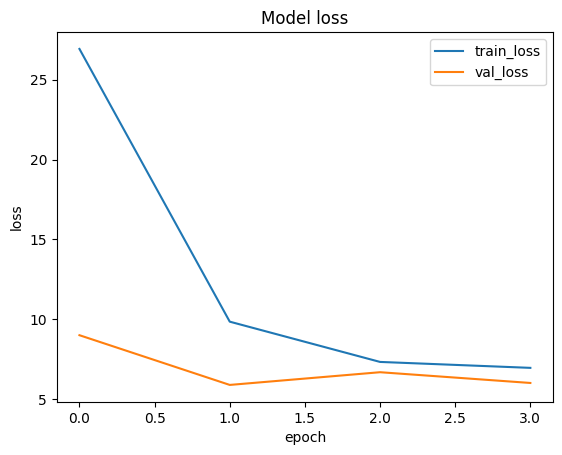

In [34]:
# Plot the training artifacts
history.history.keys()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc='upper right')
plt.show()

In [35]:
# Save the model's architecture
model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json", "w") as json_file:
    json_file.write(model_json)

### Test Keypoint Detection Performance

In [36]:
# Load model's architecture
with open('detection.json', 'r') as json_file:
    json_savedModel = json_file.read()
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)

# Load model's weights from HDF5 file
model_1_facialKeyPoints.load_weights('weights_keypoint.hdf5')

# Compile model
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer=adam, metrics=['mean_absolute_error'])

In [40]:
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print(f"Loss (MSE) on test data: {result[0]:.4f}")
print(f"Mean Absolute Error on test data: {result[1]:.4f}")

54/54 [==============================] - 1s 11ms/step - loss: 197.9648 - mean_absolute_error: 6.0883
Loss (MSE) on test data: 197.9648
Mean Absolute Error on test data: 6.0883


## Part II: Detect Emotion from Facial Expression

In [ ]:
facialexpression_df = pd.read_csv('icml_face_data.csv')

In [49]:
print(facialexpression_df.shape)
facialexpression_df.head()

(24568, 2)


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


In [52]:
# Helper functions
def string2array(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

def resize(x):
    # Resize images from (48, 48) to (96, 96)
    img = x.reshape(48, 48)
    return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [53]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [55]:
assert facialexpression_df.isnull().sum().sum() == 0

### Visualize some facial expressions

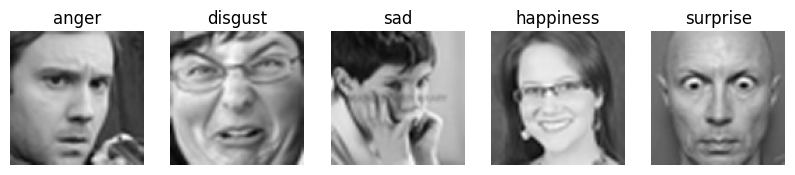

In [59]:
emotions = {0: 'anger', 1: 'disgust', 2: 'sad', 3: 'happiness', 4: 'surprise'}

plt.figure(figsize=(10, 5))
for idx, emotion in emotions.items():
    data = facialexpression_df[facialexpression_df['emotion'] == idx][:1]
    img_pixels = data[' pixels'].item().reshape(96, 96)

    plt.subplot(1, 5, idx+1)
    plt.title(emotion)
    plt.imshow(img_pixels, cmap='gray')
    plt.axis('off')
plt.show()

### Check class imbalance

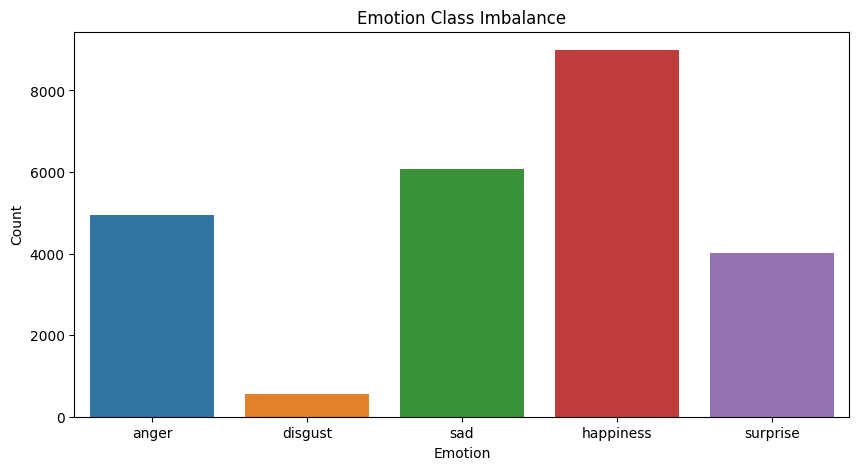

In [66]:
facialexpression_df['emotion_str'] = facialexpression_df['emotion'].map(emotions)
val_cnt = facialexpression_df['emotion_str'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=val_cnt.index, y=val_cnt, order=emotions.values())
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Class Imbalance')

plt.show()

### Prepare and Augment Data

In [109]:
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

In [110]:
X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)
X /= 255  # Normalize
print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True)

In [112]:
print(X_train.shape, X_test.shape, X_val.shape)

(22111, 96, 96, 1) (1229, 96, 96, 1) (1228, 96, 96, 1)


In [88]:
print(y_train.shape, y_test.shape, y_val.shape)

(22111, 5) (1229, 5) (1228, 5)


In [89]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

### Build the model

In [90]:
def build_model(input_shape):
    # Input tensor shape
    X_input = Input(input_shape)

    # Zero-padding
    X = ZeroPadding2D((3, 3))(X_input)

    # 1 - stage
    X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides= (2, 2))(X)

    # 2 - stage
    X = res_block(X, filter= [64, 64, 256], stage= 2)

    # 3 - stage
    X = res_block(X, filter= [128, 128, 512], stage= 3)

    # 4 - stage
    # X = res_block(X, filter= [256, 256, 1024], stage= 4)

    # Average Pooling
    X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

    # Final layer
    X = Flatten()(X)
    X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

    model = tf.keras.Model(inputs=X_input, outputs=X)
    return model

input_shape = (96, 96, 1)
model_2_emotion = build_model(input_shape)
model_2_emotion.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 102, 102, 1)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']            

### Compile and Train the Model

In [93]:
model_2_emotion.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [94]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="FacialExpression_weights.hdf5", verbose=1, save_best_only=True)

In [97]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
                              validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
                              epochs=4, callbacks=[checkpointer, earlystopping])

Epoch 1/4
345/345 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.6868
Epoch 1: val_loss did not improve from 0.92494
345/345 [==============================] - 33s 94ms/step - loss: 0.8065 - accuracy: 0.6868 - val_loss: 1.0728 - val_accuracy: 0.5912
Epoch 2/4
345/345 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.7104
Epoch 2: val_loss did not improve from 0.92494
345/345 [==============================] - 30s 86ms/step - loss: 0.7481 - accuracy: 0.7104 - val_loss: 0.9628 - val_accuracy: 0.6254
Epoch 3/4
345/345 [==============================] - ETA: 0s - loss: 0.7185 - accuracy: 0.7218
Epoch 3: val_loss did not improve from 0.92494
345/345 [==============================] - 30s 88ms/step - loss: 0.7185 - accuracy: 0.7218 - val_loss: 0.9971 - val_accuracy: 0.5912
Epoch 4/4
345/345 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.7362
Epoch 4: val_loss did not improve from 0.92494
345/345 [========================

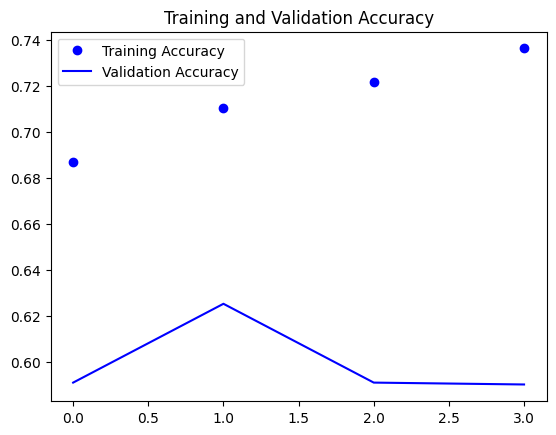

In [105]:
history.history.keys()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [98]:
# Saving the model architecture
model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
    json_file.write(model_json)

### Test Facial Expression Detection Performance

In [106]:
with open('emotion.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model architecture
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('weights_emotions.hdf5')
model_2_emotion.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [107]:
score = model_2_emotion.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 2s 24ms/step - loss: 0.3599 - accuracy: 0.8609
Test Accuracy: 0.8608624935150146


In [115]:
predicted_classes = np.argmax(model_2_emotion.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

39/39 [==============================] - 1s 10ms/step


<Axes: >

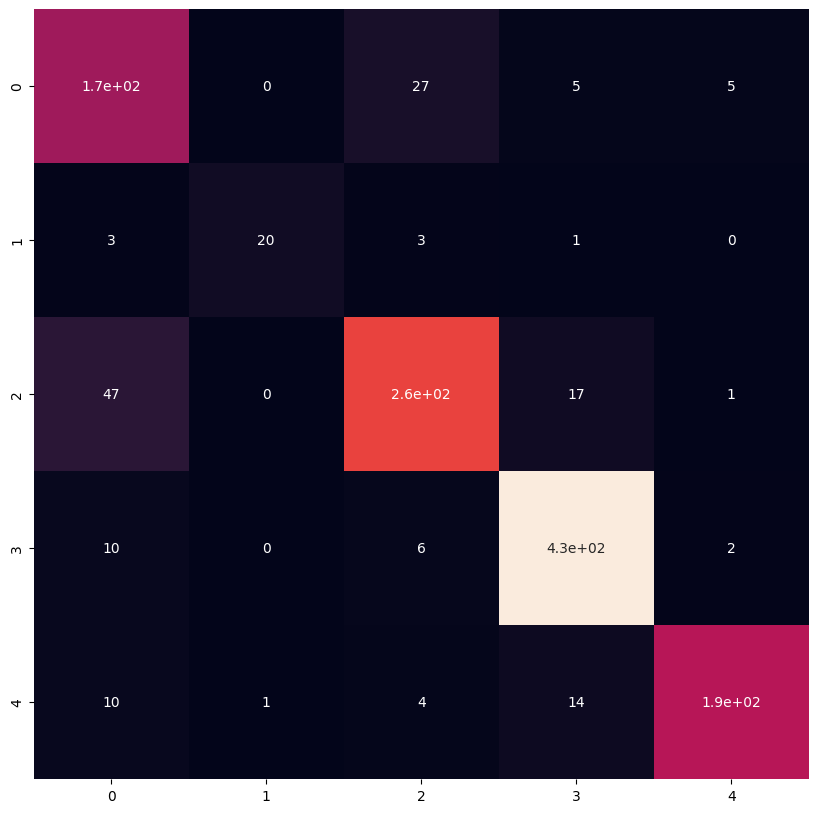

In [116]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       207
           1       0.95      0.74      0.83        27
           2       0.87      0.80      0.83       325
           3       0.92      0.96      0.94       447
           4       0.96      0.87      0.91       223

    accuracy                           0.87      1229
   macro avg       0.88      0.84      0.86      1229
weighted avg       0.88      0.87      0.87      1229



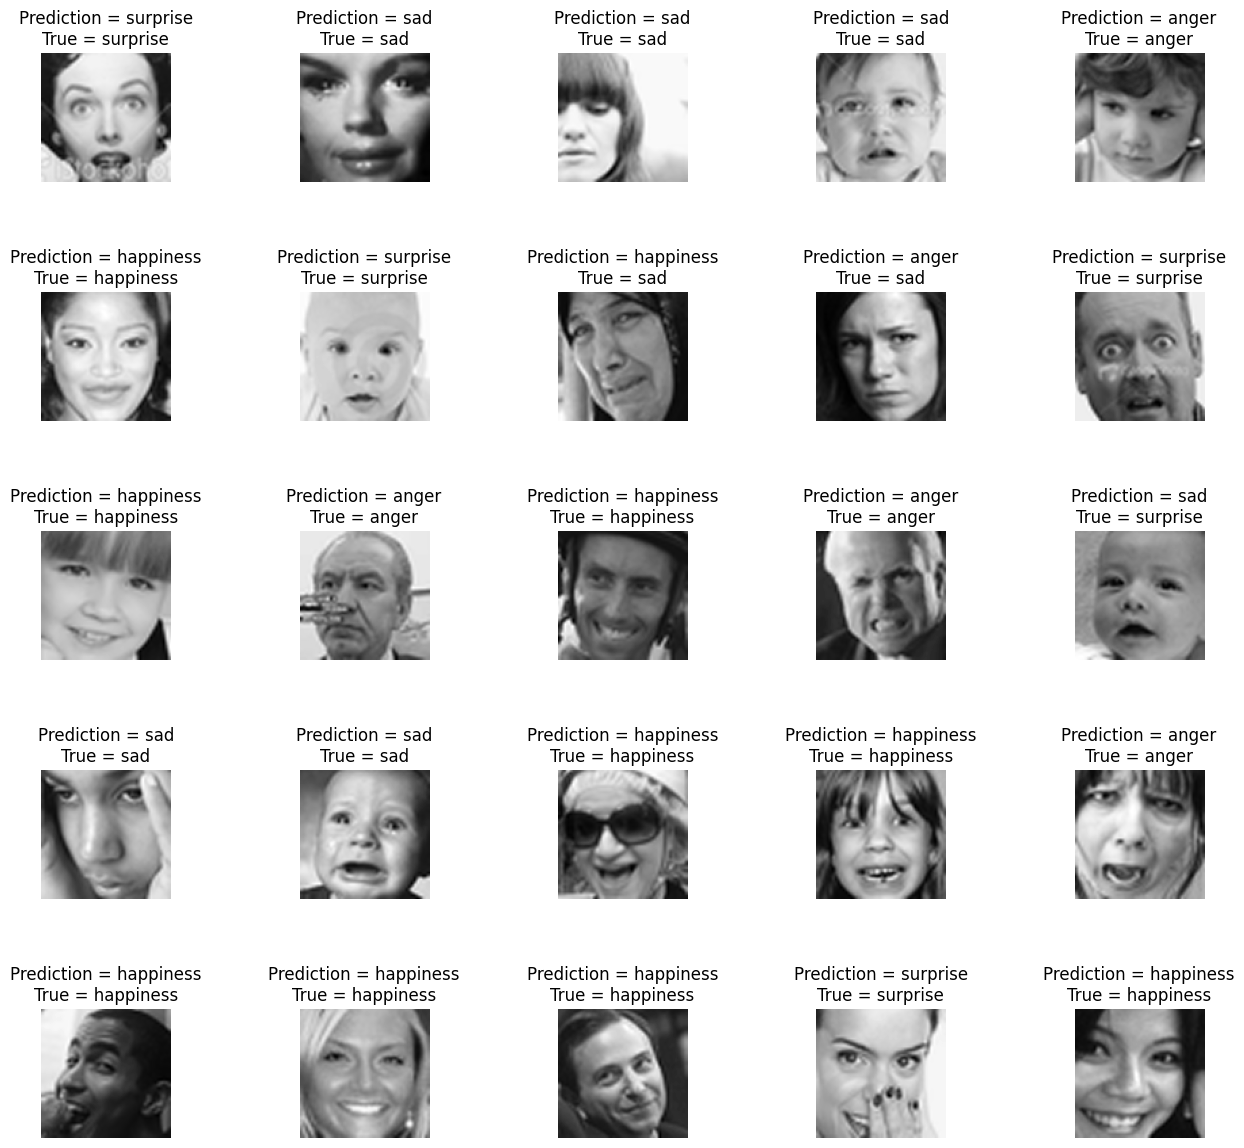

In [120]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(15, 15))

for ax, image, predicted_class, true_class in zip(axes.ravel(), X_test[:L*W], predicted_classes, y_true):
    ax.imshow(image.reshape(96, 96), cmap='gray')
    ax.set_title(f"Prediction = {emotions[predicted_class]}\nTrue = {emotions[true_class]}")
    ax.axis('off')

plt.subplots_adjust(wspace=1)

## Part III: Combine Facial Keypoint Detection and Facial Expression Model